In [29]:
import esutil as eu
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.coordinates import SkyCoord
from astropy import units as u

In [30]:
# module to match objects
h=eu.htm.HTM(10)

In [31]:
# source file paths
dp502data = "/pnfs/des/persistent/gw/exp/20170817/668439/dp502/i_36/WS0502_668439_GW1971-233_combined_i_36+fakeSN_autoScan.out"
dp502radec = "/pnfs/des/persistent/gw/exp/20170817/668439/dp502/i_36/WS0502_668439_GW1971-233_combined_i_36+fakeSN_filterObj.out"

dp57data = "/data/des60.b/data/nglaeser/gw_workflow/diff5/WS0057_668439_WS1971-233_combined_i_36+fakeSN_autoScan.out"
dp57radec = "/data/des60.b/data/nglaeser/gw_workflow/diff5/WS0057_668439_WS1971-233_combined_i_36+fakeSN_filterObj.out"

In [32]:
#***** original dp502 data from /pnfs/ *****#
data502 = np.genfromtxt(dp502data, usecols=(1,2,3), skip_header=3)
df1= pd.DataFrame(data502, columns=["SNOBJID", "SCORE", "FLUX"])

# get the RA, DEC corresponding to the SNOBJIDs
radec502 = np.genfromtxt(dp502radec, usecols=(1,17,8,9), skip_header=18, skip_footer=6)
df2= pd.DataFrame(radec502, columns=["SNOBJID", "FLUX_ERR", "RA","DEC"])

# merge on the ID
dp502 = pd.merge(df1, df2, on="SNOBJID")

ra502=dp502["RA"].values
dec502=dp502["DEC"].values

# get significant candidates
cand=dp502.loc[(dp502["SCORE"] > 0.959) & (dp502["SCORE"] < 0.961)]
cand

,SNOBJID,SCORE,FLUX,FLUX_ERR,RA,DEC
35,10331171.0,0.96,367993.59375,1862.475,197.450366,-23.381511
37,10331173.0,0.96,560070.00000,2039.804,197.451498,-23.384707


In [33]:
# convert these candidates to hh:mm:ss
decminutes=.384707*60
decseconds=(decminutes-int(decminutes))*60

raminutes=.451498*60
raseconds=(raminutes-int(raminutes))*60

print "DEC: -23:%s:%s" % (int(decminutes), decseconds)
print "RA: 197:%s:%s" % (int(raminutes), raseconds)

DEC: -23:23:4.9452
RA: 197:27:5.3928


In [34]:
# new data dp57 from diff5
data57 = np.genfromtxt(dp57data, usecols=(1,2,3), skip_header=3)
df3= pd.DataFrame(data57, columns=["SNOBJID", "SCORE", "FLUX"])

# get the RA, DEC corresponding to the SNOBJIDs
radec57 = np.genfromtxt(dp57radec, usecols=(1,17,8,9), skip_header=18, skip_footer=6)
df4= pd.DataFrame(radec57, columns=["SNOBJID", "FLUX_ERR", "RA","DEC"])

# merge on the ID
dp57 = pd.merge(df3, df4, on="SNOBJID")

ra57=dp57["RA"].values
dec57=dp57["DEC"].values

#dp57
dp57.loc[(dp57["SCORE"] > 0.9)]

,SNOBJID,SCORE,FLUX,FLUX_ERR,RA,DEC
39,15935015.0,0.93,365781.5625,1875.716,197.450377,-23.381519


In [35]:
# match up coordinates
matches502, matches57, dist = h.match(ra502, dec502, ra57, dec57, 3./3600, maxmatch=1)
# match within 1 arcsec, best match only

#print matches502
#print matches57

In [36]:
overlaps=np.column_stack([np.array(dp502)[matches502],np.array(dp57)[matches57]])
df5 = pd.DataFrame(overlaps, columns=["SNOBJID502", "SCORE502", "FLUX502", "FLUX_ERR502", "RA502", "DEC502", "SNOBJID57", "SCORE57", "FLUX57", "FLUX_ERR57", "RA57", "DEC57"])

# add deltaML row
df5 = df5.assign(deltaML=pd.Series(df5["SCORE57"]-df5["SCORE502"]))
# and an average score row
df5 = df5.assign(SCORE=pd.Series(0.5*(df5["SCORE502"]+df5["SCORE57"])))
# and a deltaflux row
df5 = df5.assign(DELTA_FLUX=pd.Series(df5["FLUX57"]-df5["FLUX502"]))
# AND a combined flux err row
df5 = df5.assign(FLUX_ERR=pd.Series(df5["FLUX_ERR502"]+df5["FLUX_ERR57"]))

only502=dp502.loc[~dp502["SNOBJID"].isin(df5["SNOBJID502"])]
only57=dp57.loc[~dp57["SNOBJID"].isin(df5["SNOBJID57"])]

df5.loc[(df5["SCORE502"] > 0.959) & (df5["SCORE502"] < 0.961)]

,SNOBJID502,SCORE502,FLUX502,FLUX_ERR502,RA502,DEC502,SNOBJID57,SCORE57,FLUX57,FLUX_ERR57,RA57,DEC57,deltaML,SCORE,DELTA_FLUX,FLUX_ERR
32,10331171.0,0.96,367993.59375,1862.475,197.450366,-23.381511,15935015.0,0.93,365781.5625,1875.716,197.450377,-23.381519,-0.03,0.945,-2212.03125,3738.191


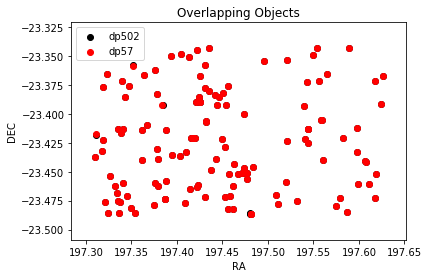

In [37]:
# plot RA,DEC of overlaps
x1 = df5["RA502"]
y1 = df5["DEC502"]

x2 = df5["RA57"]
y2 = df5["DEC57"]

overlaps = plt.subplot()
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Overlapping Objects')

plt.scatter(x1, y1, color="black", label="dp502")
plt.scatter(x2, y2, color="red", label="dp57")
plt.legend()

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/overlaps.png')

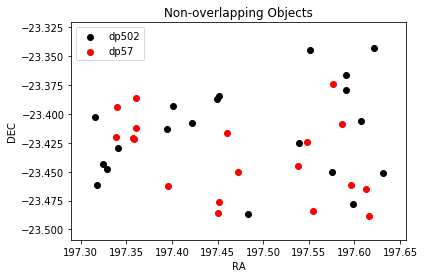

In [38]:
# of non-overlaps also
x3 = only502["RA"]
y3 = only502["DEC"]

x4 = only57["RA"]
y4 = only57["DEC"]

plt.scatter(x3, y3, color="black", label="dp502")
plt.scatter(x4, y4, color="red", label="dp57")

plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Non-overlapping Objects')
plt.legend()

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/nonoverlaps.png')

In [39]:
fraction=float(len(df5))/len(dp502)
fraction

0.869281045751634

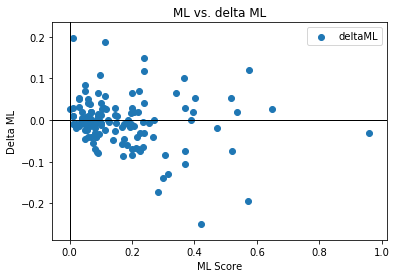

In [49]:
# plot ML score vs. delta ML score
deltaML = df5[["SCORE", "deltaML"]]

# select only rows with similar ML scores
deltaML = deltaML.loc[deltaML["deltaML"] < 0.05]

x = df5["SCORE502"]
y = df5["deltaML"]

plt.scatter(x, y)

plt.axhline(y=0, color='k', lw=1)
plt.axvline(x=0, color='k', lw=1)

plt.xlabel('ML Score')
plt.ylabel('Delta ML')
plt.title('ML vs. delta ML')
plt.legend()

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/deltaML.png')

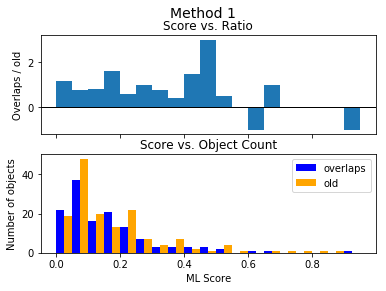

In [41]:
# ML score bins vs. ratio overlap/old
#***** (1)"overlap" as ra/dec only 

increment = 0.05
bins = np.arange(0,1,increment)
ratios = []
overlaps = []
olds = []
for i in range(len(bins)-1):
    overlap = len(df5.loc[(df5["SCORE"]>=bins[i]) & (df5["SCORE"]<bins[i+1])])
    old=1
    if overlap != 0:
        old = len(dp502.loc[(dp502["SCORE"]>=bins[i]) & (dp502["SCORE"]<bins[i+1])])
    #print "bins: %s\toverlap: %s\told: %s" % (bins[i], overlap, old)
    
    overlaps.append(overlap)
    olds.append(old)
    
    if old == 0:
        ratios.append(-1)
        continue
    ratios.append(float(overlap)/old)

m1, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(bins[:-1], ratios, increment, align='edge')
ax1.axhline(y=0, color='k', lw=1)
ax1.set_title('Score vs. Ratio')
ax1.set_ylabel('Overlaps / old')

ax2.bar(bins[:-1], overlaps, increment/2, color='blue', align='edge', label='overlaps')
ax2.bar(bins[:-1]+increment/2, olds, increment/2, color='orange', align='edge', label='old')
ax2.set_title('Score vs. Object Count')
ax2.set_xlabel('ML Score')
ax2.set_ylabel('Number of objects')

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
m1.suptitle("Method 1", fontsize=14)

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/ratios1.png')

0.857142857143


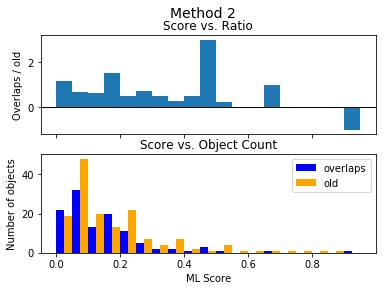

In [42]:
# ML score bins vs. ratio overlap/old
#***** (2) ra/dec and deltaML < .05 ***

# apply deltaML cut
df6 = df5.loc[df5["deltaML"]<0.05]
print float(len(df6))/len(df5)

increment = 0.05
bins = np.arange(0,1,increment)
ratios = []
overlaps = []
olds = []
for i in range(len(bins)-1):
    overlap = len(df6.loc[(df5["SCORE"]>=bins[i]) & (df6["SCORE"]<bins[i+1])])
    old=1
    if overlap != 0:
        old = len(dp502.loc[(dp502["SCORE"]>=bins[i]) & (dp502["SCORE"]<bins[i+1])])
    #print "bins: %s\toverlap: %s\told: %s" % (bins[i], overlap, old)
    
    overlaps.append(overlap)
    olds.append(old)
    
    if old == 0:
        ratios.append(-1)
        continue
    ratios.append(float(overlap)/old)

m2, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(bins[:-1], ratios, increment, align='edge')
ax1.axhline(y=0, color='k', lw=1)
ax1.set_title('Score vs. Ratio')
ax1.set_ylabel('Overlaps / old')

ax2.bar(bins[:-1], overlaps, increment/2, color='blue', align='edge', label='overlaps')
ax2.bar(bins[:-1]+increment/2, olds, increment/2, color='orange', align='edge', label='old')
ax2.set_title('Score vs. Object Count')
ax2.set_xlabel('ML Score')
ax2.set_ylabel('Number of objects')

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
m2.suptitle("Method 2", fontsize=14)

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/ratios2.png')

0.947368421053


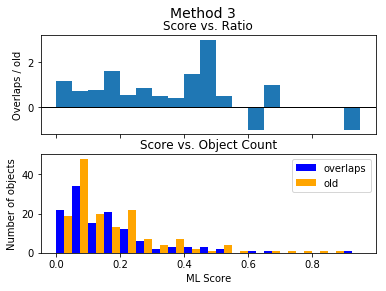

In [43]:
# ML score bins vs. ratio overlap/old
#**** (3) ra/dec and deltaFlux < 1sigma ***

# apply deltaFlux cut
df7 = df5.loc[(df5["DELTA_FLUX"]/df5["FLUX_ERR"])<1]
print float(len(df7))/len(df5)

increment = 0.05
bins = np.arange(0,1,increment)
ratios = []
overlaps = []
olds = []
for i in range(len(bins)-1):
    overlap = len(df7.loc[(df5["SCORE"]>=bins[i]) & (df7["SCORE"]<bins[i+1])])
    old=1
    if overlap != 0:
        old = len(dp502.loc[(dp502["SCORE"]>=bins[i]) & (dp502["SCORE"]<bins[i+1])])
    #print "bins: %s\toverlap: %s\told: %s" % (bins[i], overlap, old)
    
    overlaps.append(overlap)
    olds.append(old)
    
    if old == 0:
        ratios.append(-1)
        continue
    ratios.append(float(overlap)/old)

m3, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(bins[:-1], ratios, increment, align='edge')
ax1.axhline(y=0, color='k', lw=1)
ax1.set_title('Score vs. Ratio')
ax1.set_ylabel('Overlaps / old')

ax2.bar(bins[:-1], overlaps, increment/2, color='blue', align='edge', label='overlaps')
ax2.bar(bins[:-1]+increment/2, olds, increment/2, color='orange', align='edge', label='old')
ax2.set_title('Score vs. Object Count')
ax2.set_xlabel('ML Score')
ax2.set_ylabel('Number of objects')

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels)
m3.suptitle("Method 3", fontsize=14)

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/ratios3.png')

# delta flux: flux_old and flux_new
# if uncorrelated , new error = sqrt(sum of squares)
# if correlated fully, new error = error_old+error_new <<<< do this one
# if in between, covariance matrix (don't do this now)

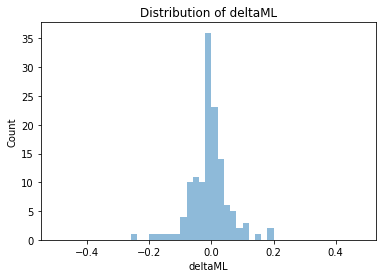

In [44]:
# plot distrib of delta ML score (should be gaussian centered at 0, small width) (1d)

increment=0.02
bins = np.arange(-0.5,0.5,increment)
data = df5["deltaML"]
n, bins, patches = plt.hist(data, bins, density=0, alpha=0.5)
plt.title('Distribution of deltaML')
plt.xlabel('deltaML')
plt.ylabel('Count')

#from scipy.stats import norm
#mu, std = norm.fit(data)
#x = np.linspace(min(data), max(data))
#p = norm.pdf(x, mu, std)
#plt.plot(x, p, 'k', linewidth=2)

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/deltaMLdistrib.png')

In [45]:
# ML scores of non-overlap objects
print only502[["SCORE", "RA", "DEC"]]
print
print only57[["SCORE", "RA", "DEC"]]

     SCORE          RA        DEC
4    0.055  197.394709 -23.412819
5    0.115  197.401146 -23.392692
20   0.290  197.422168 -23.407433
37   0.960  197.451498 -23.384707
39   0.573  197.448848 -23.386741
63   0.030  197.483256 -23.486625
71   0.205  197.539243 -23.424755
79   0.040  197.551780 -23.344558
81   0.380  197.607692 -23.406482
82   0.060  197.590197 -23.365984
84   0.265  197.590424 -23.379469
88   0.080  197.598120 -23.478217
95   0.307  197.621954 -23.342951
98   0.547  197.631142 -23.451223
108  0.060  197.575367 -23.449831
111  0.150  197.315425 -23.402227
112  0.220  197.317656 -23.461251
119  0.230  197.323880 -23.443671
121  0.030  197.328637 -23.447374
131  0.083  197.340751 -23.429512

     SCORE          RA        DEC
9    0.070  197.396059 -23.462614
42   0.050  197.449936 -23.486009
43   0.040  197.451935 -23.476512
51   0.832  197.460322 -23.416678
59   0.030  197.472339 -23.450509
74   0.248  197.537943 -23.445251
80   0.190  197.548496 -23.424353
83   0.090  1

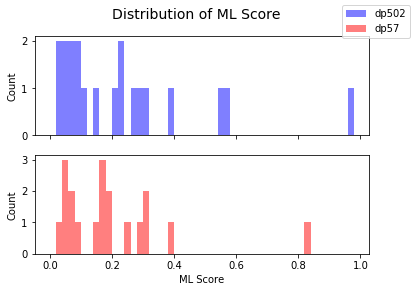

In [46]:
# non-overlap ML distribution
increment=0.02
bins = np.arange(0,1,increment)

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
plt.suptitle('Distribution of ML Score', fontsize=14)
plt.xlabel('ML Score')

ax1.hist(only502["SCORE"], bins, facecolor='blue', density=0, alpha=0.5, label='dp502')
ax1.set_ylabel('Count')
ax2.hist(only57["SCORE"], bins, facecolor='red', density=0, alpha=0.5, label='dp57')
ax2.set_ylabel('Count')

f.legend()

plt.savefig('/data/des60.b/data/nglaeser/gw_workflow/plots/dp57-dp502/unmatchedMLdistrib.png')

# Objects
### Overlaps

Notice that, for the most part, the RA/DEC is very similar (tolerance 1") so there is only one color showing:
![Overlap objects](files/dp57-dp502/overlaps.png "Overlaps")
Fraction = 0.8431372549019608

### Non-overlaps
![Non-overlap objects](files/dp57-dp502/nonoverlaps.png "Non-overlaps")

# ML Scores
### ML Score vs. $\Delta{ML}$
Where $\Delta{ML} = ML_{new} - ML_{old}$
![ML vs. deltaML](files/dp57-dp502/deltaML.png "ML vs. deltaML")

### ML Score Bins vs. Count
In three ways: (1) using only RA/DEC for overlap calculation, (2) using RA/DEC and $\Delta{ML}<0.05$, and (3) using RA/DEC and $\Delta{\Phi}<1\sigma$.

| | 
-|-|-
![ML vs. number and ratio of objects](files/dp57-dp502/ratios1.png "ML vs. Count: Method 1")| ![ML vs. number and ratio of objects](files/dp57-dp502/ratios2.png "ML vs. Count: Method 2") |![ML vs. number and ratio of objects](files/dp57-dp502/ratios3.png "ML vs. Count: Method 3") 
 |Fraction = 0.860465116279 |Fraction = 0.961240310078 

### ML Score Distribution
$\Delta{ML}$ distribution of matches:
![DeltaML Distribution](files/dp57-dp502/deltaMLdistrib.png "DeltaML Distribution")

ML score distribution of non-matches:
![Unmatched ML Distribution](files/dp57-dp502/unmatchedMLdistrib.png "ML Distribution of Unmatched Objects")

# Diffimg Comparison
Left: dp57, right: dp502
![diffimg side-by-side](files/dp57-dp502/dp57-dp502.png "Diffimg side-by-side")

dp57 used both August and September templates while dp502 used **only** the (less noisy) August templates.